<a href="https://colab.research.google.com/github/isnanmulia/colab-machinelearning/blob/main/ML_ReinforcementLearning_QLearning_Animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# ======================================================
# 1. Define the warehouse grid environment
# ======================================================

class WarehouseEnv:
    def __init__(self):
        self.rows = 6
        self.cols = 6

        self.obstacles = {(1,1), (1,2), (3,4), (3,5)}
        self.congested = {(0,3), (2,3), (4,1)}
        self.start = (0,0)
        self.goal = (5,5)

        self.state = self.start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        r, c = self.state

        if action == 0:  # up
            nr, nc = r - 1, c
        elif action == 1:  # down
            nr, nc = r + 1, c
        elif action == 2:  # left
            nr, nc = r, c - 1
        elif action == 3:  # right
            nr, nc = r, c + 1

        next_state = (nr, nc)

        # Hit wall?
        if nr < 0 or nr >= self.rows or nc < 0 or nc >= self.cols:
            reward = -5
            next_state = self.state
        # Hit obstacle?
        elif next_state in self.obstacles:
            reward = -5
            next_state = self.state
        # Goal?
        elif next_state == self.goal:
            reward = +10
        # Congested?
        elif next_state in self.congested:
            reward = -3
        else:
            reward = -1

        self.state = next_state
        done = (next_state == self.goal)

        return next_state, reward, done


# ======================================================
# 2. Train with Q-Learning
# ======================================================

env = WarehouseEnv()
actions = 4
Q = np.zeros((env.rows, env.cols, actions))

alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 500

def epsilon_greedy(state):
    if random.random() < epsilon:
        return random.randint(0, actions-1)
    r, c = state
    return np.argmax(Q[r,c])

# Train
for ep in range(episodes):
    state = env.reset()
    while True:
        action = epsilon_greedy(state)
        next_state, reward, done = env.step(action)
        r, c = state
        nr, nc = next_state

        Q[r,c,action] += alpha * (reward + gamma * np.max(Q[nr,nc]) - Q[r,c,action])
        state = next_state
        if done:
            break

# ======================================================
# 3. Extract optimal path from Q-table
# ======================================================

def extract_optimal_path():
    state = env.start
    path = [state]
    visited = set()

    for _ in range(50):
        r, c = state
        action = np.argmax(Q[r,c])

        if action == 0: nxt = (r-1, c)
        elif action == 1: nxt = (r+1, c)
        elif action == 2: nxt = (r, c-1)
        elif action == 3: nxt = (r, c+1)

        if nxt in visited:
            break

        visited.add(nxt)
        path.append(nxt)
        state = nxt

        if state == env.goal:
            break

    return path

path = extract_optimal_path()
path


[(0, 0),
 (1, 0),
 (2, 0),
 (2, 1),
 (3, 1),
 (3, 2),
 (3, 3),
 (4, 3),
 (5, 3),
 (5, 4),
 (5, 5)]

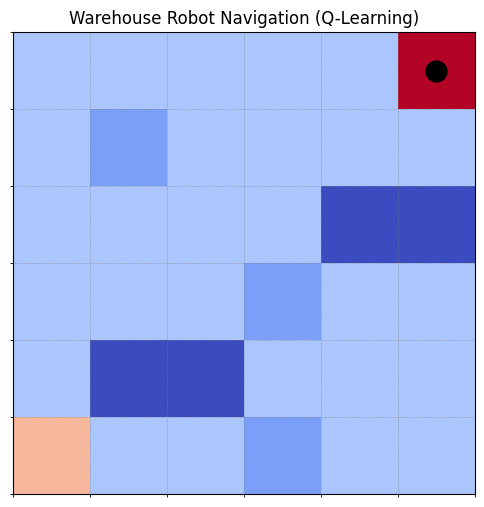

In [9]:
# === Fixed Animation Block for Colab ===

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# assume `env` and `path` already exist from training / extraction

# Create a grid for visualization
grid = np.zeros((env.rows, env.cols))

for (r,c) in env.obstacles:
    grid[r,c] = -5  # obstacles

for (r,c) in env.congested:
    grid[r,c] = -2  # congested areas

# Mark start & goal
sr, sc = env.start
gr, gc = env.goal
grid[sr,sc] = 5
grid[gr,gc] = 10

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("Warehouse Robot Navigation (Q-Learning)")

im = ax.imshow(grid, cmap="coolwarm", interpolation="nearest")
robot_marker, = ax.plot([], [], "ko", markersize=15)  # robot dot

# invert Y so 0,0 is upper-left visually
ax.invert_yaxis()
ax.set_xticks(np.arange(-0.5, env.cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, env.rows, 1), minor=True)
ax.grid(which="minor", color="gray", linestyle=":", linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])

def init():
    robot_marker.set_data([], [])
    return (robot_marker,)

def update(frame):
    # frame is an index into path
    y, x = path[frame]
    # set_data expects sequences, so wrap scalars in lists
    robot_marker.set_data([x], [y])
    return (robot_marker,)

# Use frames as a range to ensure integer indexes
ani = FuncAnimation(fig, update, frames=range(len(path)), init_func=init,
                    interval=600, blit=True)

# Display as HTML5 animation in Colab
HTML(ani.to_jshtml())
